In [3]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
plt.style.use('dark_background')

Using TensorFlow backend.


In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(28, 28)


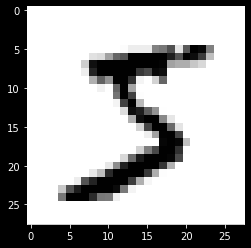

In [5]:
image_A = train_images[0]
print(image_A.shape)
plt.imshow(image_A, cmap = plt.cm.binary)

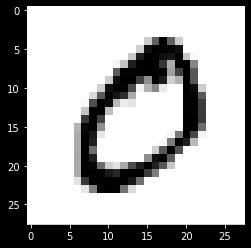

In [6]:
image_B = train_images[1]
plt.imshow(image_B, cmap = plt.cm.binary)

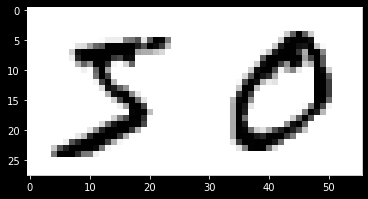

In [7]:
images_A_and_B = np.hstack((image_A, image_B))
plt.imshow(images_A_and_B, cmap = plt.cm.binary)

In [8]:
# Create mini training set so that it's not too computationally intensive
mini_size = 500
mini_X_train, mini_X_test, mini_y_train, mini_y_test = train_images[:mini_size], train_images[mini_size:mini_size*2],  train_labels[:mini_size], train_labels[mini_size:mini_size*2]



In [9]:
num_images = mini_X_train.shape[0]
index_list = np.linspace(0,num_images-1,num_images).astype(int)
image_combinations = list(itertools.combinations(index_list, 2))

In [10]:
# First just try putting them one on top of the other
concatenated_dataset_X = []
concatenated_dataset_y = []

for combination in image_combinations:
#     print(combination)
    
    index_A = combination[0]
    index_B = combination[1]
    
    image_A = mini_X_train[index_A]
    image_B = mini_X_train[index_B]
    
    intermediate_label_A = mini_y_train[index_A]
    intermediate_label_B = mini_y_train[index_B]
    
    concatenated_images = np.hstack((image_A, image_B))
    
    final_label = min(intermediate_label_A, intermediate_label_B)
    
    concatenated_dataset_X.append(concatenated_images)
    concatenated_dataset_y.append(final_label)

In [11]:
num_images = mini_X_test.shape[0]
index_list = np.linspace(0,num_images-1,num_images).astype(int)
image_combinations = list(itertools.combinations(index_list, 2))

In [12]:
# As above for test
concatenated_dataset_X_test = []
concatenated_dataset_y_test = []

for combination in image_combinations:
#     print(combination)
    
    index_A = combination[0]
    index_B = combination[1]
    
    image_A = mini_X_test[index_A]
    image_B = mini_X_test[index_B]
    
    intermediate_label_A = mini_y_test[index_A]
    intermediate_label_B = mini_y_test[index_B]
    
    concatenated_images = np.hstack((image_A, image_B))
    
    final_label = min(intermediate_label_A, intermediate_label_B)
    
    concatenated_dataset_X_test.append(concatenated_images)
    concatenated_dataset_y_test.append(final_label)

In [13]:
# To array
concatenated_dataset_X = np.array(concatenated_dataset_X)
concatenated_dataset_y = np.array(concatenated_dataset_y)

concatenated_dataset_X_test = np.array(concatenated_dataset_X_test)
concatenated_dataset_y_test = np.array(concatenated_dataset_y_test)

print(concatenated_dataset_X.shape)
print(concatenated_dataset_X_test.shape)

(124750, 28, 56)
(124750, 28, 56)


In [14]:
train_images = concatenated_dataset_X.reshape((124750, 28, 56, 1))
train_images = train_images.astype('float32')/ 255

test_images = concatenated_dataset_X_test.reshape((124750, 28, 56, 1))
test_images = test_images.astype('float32')/255

train_labels = to_categorical(concatenated_dataset_y)
test_labels = to_categorical(concatenated_dataset_y_test)

In [15]:
# Check shapes
print(train_images.shape)
print(train_labels.shape)

(124750, 28, 56, 1)
(124750, 10)


In [16]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,56,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
# Adding a classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 54, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 27, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 12, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 10, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [18]:
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [ ]:
# Run model in one go
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

In [27]:
# i = 0
# val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
# val_data.shape

(31187, 28, 56, 1)

In [ ]:
# Set up parameters for cross-validation
k = 4
num_val_samples = len(train_images)//k

In [29]:
# Try with more epochs

num_epochs = 3
all_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy', 'mae'])
    
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    #val_acc_history = history.history['accuracy']
    #print(history.history.keys())
    all_mae_histories.append(val_mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

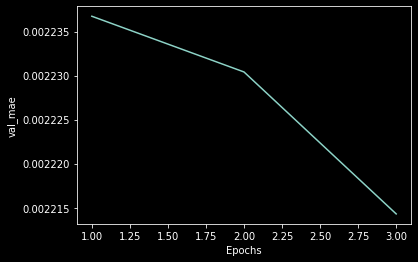

In [32]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()

In [33]:
def smooth_curve(points, factor =0.9):
    
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

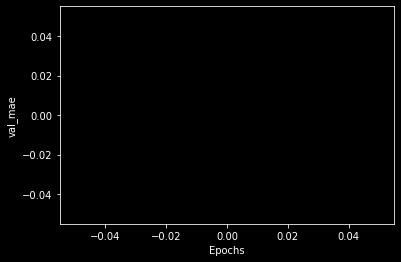

In [34]:
# Difficult to understand plot due to scaling issues
plt.plot(range(1, len(smooth_mae_history[10:500]) + 1), smooth_mae_history[10:500])
plt.xlabel('Epochs')
plt.ylabel('val_mae')
plt.show()